_Note (Mac OS): To ensure all dependencies are available set env virable as follows:_
```
    export DYLD_LIBRARY_PATH=/home/user/path_to_CUDNN_folder:$DYLD_LIBRARY_PATH
    export CPATH=/home/user/path_to_CUDNN_folder/include:$CPATH
    export LIBRARY_PATH=/home/user/path_to_CUDNN_folder:$DYLD_LIBRARY_PATH
```
_See details [here](http://deeplearning.net/software/theano/library/sandbox/cuda/dnn.html)_.

In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
import lasagne
import numpy as np
import pickle
import skimage.transform
import scipy

import theano
import theano.tensor as T

from lasagne.utils import floatX

Using gpu device 0: GeForce GT 750M (CNMeM is disabled)


### Memory optimization

Use the following cell if you have any memory issues (generally for old generations of NVIDIA cards, like on GForce 750M with 2G memory)

In [3]:
theano.config.allow_gc = True
theano.config.scan.allow_output_prealloc = False
theano.config.exception_verbosity = 'high'
theano.config.optimizer = 'fast_compile'

### VGG-19
* 19-layer model from the paper
* See "Very Deep Convolutional Networks for Large-Scale Image Recognition"
* Original source: https://gist.github.com/ksimonyan/3785162f95cd2d5fee77
* License: non-commercial use only

_Note: in case of low-memory cards use IMAGEWIDTH <= 450_

In [4]:
from lasagne.layers import InputLayer, DenseLayer, NonlinearityLayer
from lasagne.layers.dnn import Conv2DDNNLayer as ConvLayer
from lasagne.layers import Pool2DLayer as PoolLayer
from lasagne.nonlinearities import softmax

IMAGEWIDTH = 300

# Note: tweaked to use average pooling instead of maxpooling
def build_model():
    net = {}
    net['input'] = InputLayer((1, 3, IMAGEWIDTH, IMAGEWIDTH))
    net['conv1_1'] = ConvLayer(net['input'], 64, 3, pad=1)
    net['conv1_2'] = ConvLayer(net['conv1_1'], 64, 3, pad=1)
    net['pool1'] = PoolLayer(net['conv1_2'], 2, mode='average_exc_pad')
    net['conv2_1'] = ConvLayer(net['pool1'], 128, 3, pad=1)
    net['conv2_2'] = ConvLayer(net['conv2_1'], 128, 3, pad=1)
    net['pool2'] = PoolLayer(net['conv2_2'], 2, mode='average_exc_pad')
    net['conv3_1'] = ConvLayer(net['pool2'], 256, 3, pad=1)
    net['conv3_2'] = ConvLayer(net['conv3_1'], 256, 3, pad=1)
    net['conv3_3'] = ConvLayer(net['conv3_2'], 256, 3, pad=1)
    net['conv3_4'] = ConvLayer(net['conv3_3'], 256, 3, pad=1)
    net['pool3'] = PoolLayer(net['conv3_4'], 2, mode='average_exc_pad')
    net['conv4_1'] = ConvLayer(net['pool3'], 512, 3, pad=1)
    net['conv4_2'] = ConvLayer(net['conv4_1'], 512, 3, pad=1)
    net['conv4_3'] = ConvLayer(net['conv4_2'], 512, 3, pad=1)
    net['conv4_4'] = ConvLayer(net['conv4_3'], 512, 3, pad=1)
    net['pool4'] = PoolLayer(net['conv4_4'], 2, mode='average_exc_pad')
    net['conv5_1'] = ConvLayer(net['pool4'], 512, 3, pad=1)
    net['conv5_2'] = ConvLayer(net['conv5_1'], 512, 3, pad=1)
    net['conv5_3'] = ConvLayer(net['conv5_2'], 512, 3, pad=1)
    net['conv5_4'] = ConvLayer(net['conv5_3'], 512, 3, pad=1)
    net['pool5'] = PoolLayer(net['conv5_4'], 2, mode='average_exc_pad')

    return net

### Download the normalized pretrained weights from:
https://s3.amazonaws.com/lasagne/recipes/pretrained/imagenet/vgg19_normalized.pkl
(original source: https://bethgelab.org/deepneuralart/)

_Note: On Mac install wget via homberew. See details [here](http://stackoverflow.com/a/17094214)_.

In [6]:
net = build_model()

values = pickle.load(open('../models/vgg19_normalized.pkl'))['param values']
lasagne.layers.set_all_param_values(net['pool5'], [v.astype(np.float32) for v in values])

In [7]:
MEAN_VALUES = np.array([104, 117, 123]).reshape((3,1,1))

def prep_image(im):
    if len(im.shape) == 2:
        im = im[:, :, np.newaxis]
        im = np.repeat(im, 3, axis=2)
    h, w, _ = im.shape
    if h < w:
        im = skimage.transform.resize(im, (IMAGEWIDTH, w*IMAGEWIDTH/h), preserve_range=True)
    else:
        im = skimage.transform.resize(im, (h*IMAGEWIDTH/w, IMAGEWIDTH), preserve_range=True)

    # Central crop
    h, w, _ = im.shape
    im = im[h//2-IMAGEWIDTH//2:h//2+IMAGEWIDTH//2, w//2-IMAGEWIDTH//2:w//2+IMAGEWIDTH//2]
    
    rawim = np.copy(im).astype('uint8')
    
    # Shuffle axes to c01
    im = np.swapaxes(np.swapaxes(im, 1, 2), 0, 1)
    
    # Convert RGB to BGR
    im = im[::-1, :, :]

    im = im - MEAN_VALUES
    return rawim, floatX(im[np.newaxis])

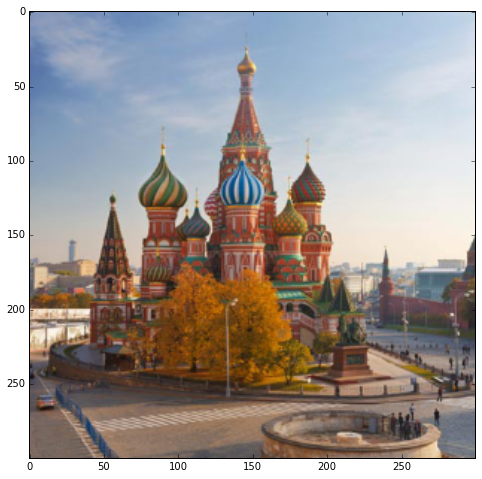

In [8]:
content = imread('../images/content/vasily.jpg')
rawim, content = prep_image(content)
plt.figure(figsize=(8,8))
plt.imshow(rawim)

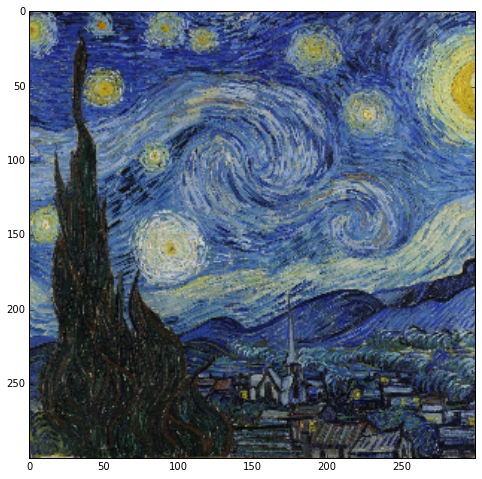

In [9]:
style = imread('../images/style/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg')
rawim, style = prep_image(style)
plt.figure(figsize=(8,8))
plt.imshow(rawim)

In [10]:
def gram_matrix(x):
    x = x.flatten(ndim=3)
    g = T.tensordot(x, x, axes=([2], [2]))
    return g


def content_loss(P, X, layer):
    p = P[layer]
    x = X[layer]
    
    loss = 1./2 * ((x - p)**2).sum()
    return loss


def style_loss(A, X, layer):
    a = A[layer]
    x = X[layer]
    
    A = gram_matrix(a)
    G = gram_matrix(x)
    
    N = a.shape[1]
    M = a.shape[2] * a.shape[3]
    
    loss = 1./(4 * N**2 * M**2) * ((G - A)**2).sum()
    return loss

def total_variation_loss(x):
    return (((x[:,:,:-1,:-1] - x[:,:,1:,:-1])**2 + (x[:,:,:-1,:-1] - x[:,:,:-1,1:])**2)**1.25).sum()

In [11]:
layers = ['conv4_2', 'conv1_1', 'conv2_1', 'conv3_1', 'conv4_1', 'conv5_1']
layers = {k: net[k] for k in layers}

In [12]:
layers

{'conv1_1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x112056050>,
 'conv2_1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x115033c50>,
 'conv3_1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x115038590>,
 'conv4_1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x117370210>,
 'conv4_2': <lasagne.layers.dnn.Conv2DDNNLayer at 0x117370250>,
 'conv5_1': <lasagne.layers.dnn.Conv2DDNNLayer at 0x117370e50>}

In [11]:
# Precompute layer activations for photo and artwork
input_im_theano = T.tensor4()
outputs = lasagne.layers.get_output(layers.values(), input_im_theano)

content_features = {k: theano.shared(output.eval({input_im_theano: content}))
                  for k, output in zip(layers.keys(), outputs)}
style_features = {k: theano.shared(output.eval({input_im_theano: style}))
                for k, output in zip(layers.keys(), outputs)}

In [12]:
# Get expressions for layer activations for generated image
generated_image = theano.shared(floatX(np.random.uniform(-128, 128, (1, 3, IMAGEWIDTH, IMAGEWIDTH))))

gen_features = lasagne.layers.get_output(layers.values(), generated_image)
gen_features = {k: v for k, v in zip(layers.keys(), gen_features)}

In [13]:
# Define loss function
losses = []

# content loss
losses.append(0.001 * content_loss(content_features, gen_features, 'conv4_2'))

# style loss
losses.append(0.2e6 * style_loss(style_features, gen_features, 'conv1_1'))
losses.append(0.2e6 * style_loss(style_features, gen_features, 'conv2_1'))
losses.append(0.2e6 * style_loss(style_features, gen_features, 'conv3_1'))
losses.append(0.2e6 * style_loss(style_features, gen_features, 'conv4_1'))
losses.append(0.2e6 * style_loss(style_features, gen_features, 'conv5_1'))

# total variation penalty
losses.append(0.1e-7 * total_variation_loss(generated_image))

total_loss = sum(losses)

In [14]:
grad = T.grad(total_loss, generated_image)

In [15]:
# Theano functions to evaluate loss and gradient
f_loss = theano.function([], total_loss)
f_grad = theano.function([], grad)

# Helper functions to interface with scipy.optimize
def eval_loss(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGEWIDTH, IMAGEWIDTH)))
    generated_image.set_value(x0)
    return f_loss().astype('float64')

def eval_grad(x0):
    x0 = floatX(x0.reshape((1, 3, IMAGEWIDTH, IMAGEWIDTH)))
    generated_image.set_value(x0)
    return np.array(f_grad()).flatten().astype('float64')

In [16]:
# Initialize with a noise image
generated_image.set_value(floatX(np.random.uniform(-128, 128, (1, 3, IMAGEWIDTH, IMAGEWIDTH))))

x0 = generated_image.get_value().astype('float64')
xs = []
xs.append(x0)

# Optimize, saving the result periodically
for i in range(8):
    print(i)
    scipy.optimize.fmin_l_bfgs_b(eval_loss, x0.flatten(), fprime=eval_grad, maxfun=40)
    x0 = generated_image.get_value().astype('float64')
    xs.append(x0)

0


MemoryError: Error allocating 23040000 bytes of device memory (out of memory).
Apply node that caused the error: GpuReshape{2}(GpuDimShuffle{2,0,1}.0, MakeVector{dtype='int64'}.0)
Toposort index: 254
Inputs types: [CudaNdarrayType(float32, 3D), TensorType(int64, vector)]
Inputs shapes: [(90000, 1, 64), (2,)]
Inputs strides: [(1, 0, 90000), (8,)]
Inputs values: ['not shown', array([90000,    64])]
Outputs clients: [[GpuDot22(GpuReshape{2}.0, GpuReshape{2}.0)]]

Debugprint of the apply node: 
GpuReshape{2} [@A] <CudaNdarrayType(float32, matrix)> ''   
 |GpuDimShuffle{2,0,1} [@B] <CudaNdarrayType(float32, 3D)> ''   
 | |GpuFlatten{3} [@C] <CudaNdarrayType(float32, 3D)> ''   
 |   |<CudaNdarrayType(float32, 4D)> [@D] <CudaNdarrayType(float32, 4D)>
 |MakeVector{dtype='int64'} [@E] <TensorType(int64, vector)> ''   
   |Prod{acc_dtype=int64} [@F] <TensorType(int64, scalar)> ''   
   | |MakeVector{dtype='int64'} [@G] <TensorType(int64, vector)> ''   
   |   |Shape_i{2} [@H] <TensorType(int64, scalar)> ''   
   |   | |<CudaNdarrayType(float32, 4D)> [@D] <CudaNdarrayType(float32, 4D)>
   |   |Shape_i{3} [@I] <TensorType(int64, scalar)> ''   
   |     |<CudaNdarrayType(float32, 4D)> [@D] <CudaNdarrayType(float32, 4D)>
   |Elemwise{mul,no_inplace} [@J] <TensorType(int64, scalar)> ''   
     |Shape_i{1} [@K] <TensorType(int64, scalar)> ''   
     | |<CudaNdarrayType(float32, 4D)> [@D] <CudaNdarrayType(float32, 4D)>
     |Shape_i{0} [@L] <TensorType(int64, scalar)> ''   
       |<CudaNdarrayType(float32, 4D)> [@D] <CudaNdarrayType(float32, 4D)>

Storage map footprint:
 - GpuReshape{2}.0, Shape: (64, 90000), ElemSize: 4 Byte(s), TotalSize: 23040000 Byte(s)
 - GpuDimShuffle{2,0,1}.0, Shape: (90000, 1, 64), ElemSize: 4 Byte(s), TotalSize: 23040000 Byte(s)
 - GpuReshape{2}.0, Shape: (64, 90000), ElemSize: 4 Byte(s), TotalSize: 23040000 Byte(s)
 - GpuElemwise{Composite{(i0 * (i1 + Abs(i1)))},no_inplace}.0, Shape: (1, 64, 300, 300), ElemSize: 4 Byte(s), TotalSize: 23040000 Byte(s)
 - GpuElemwise{add,no_inplace}.0, Shape: (1, 64, 300, 300), ElemSize: 4 Byte(s), TotalSize: 23040000 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (1, 64, 300, 300), ElemSize: 4 Byte(s), TotalSize: 23040000 Byte(s)
 - GpuReshape{2}.0, Shape: (90000, 64), ElemSize: 4 Byte(s), TotalSize: 23040000 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (1, 128, 150, 150), ElemSize: 4 Byte(s), TotalSize: 11520000 Byte(s)
 - W, Shared Input, Shape: (512, 512, 3, 3), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - W, Shared Input, Shape: (512, 512, 3, 3), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - W, Shared Input, Shape: (512, 512, 3, 3), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - W, Shared Input, Shape: (512, 512, 3, 3), ElemSize: 4 Byte(s), TotalSize: 9437184 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (1, 256, 75, 75), ElemSize: 4 Byte(s), TotalSize: 5760000 Byte(s)
 - W, Shared Input, Shape: (512, 256, 3, 3), ElemSize: 4 Byte(s), TotalSize: 4718592 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (1, 512, 37, 37), ElemSize: 4 Byte(s), TotalSize: 2803712 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (1, 512, 37, 37), ElemSize: 4 Byte(s), TotalSize: 2803712 Byte(s)
 - W, Shared Input, Shape: (256, 256, 3, 3), ElemSize: 4 Byte(s), TotalSize: 2359296 Byte(s)
 - W, Shared Input, Shape: (256, 256, 3, 3), ElemSize: 4 Byte(s), TotalSize: 2359296 Byte(s)
 - W, Shared Input, Shape: (256, 256, 3, 3), ElemSize: 4 Byte(s), TotalSize: 2359296 Byte(s)
 - W, Shared Input, Shape: (256, 128, 3, 3), ElemSize: 4 Byte(s), TotalSize: 1179648 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (1, 3, 300, 300), ElemSize: 4 Byte(s), TotalSize: 1080000 Byte(s)
 - <CudaNdarrayType(float32, 4D)>, Shared Input, Shape: (1, 512, 18, 18), ElemSize: 4 Byte(s), TotalSize: 663552 Byte(s)
 - W, Shared Input, Shape: (128, 128, 3, 3), ElemSize: 4 Byte(s), TotalSize: 589824 Byte(s)
 - W, Shared Input, Shape: (128, 64, 3, 3), ElemSize: 4 Byte(s), TotalSize: 294912 Byte(s)
 - W, Shared Input, Shape: (64, 64, 3, 3), ElemSize: 4 Byte(s), TotalSize: 147456 Byte(s)
 - GpuReshape{4}.0, Shape: (1, 64, 1, 64), ElemSize: 4 Byte(s), TotalSize: 16384 Byte(s)
 - GpuContiguous.0, Shape: (64, 3, 3, 3), ElemSize: 4 Byte(s), TotalSize: 6912 Byte(s)
 - W, Shared Input, Shape: (64, 3, 3, 3), ElemSize: 4 Byte(s), TotalSize: 6912 Byte(s)
 - b, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - b, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - b, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - b, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - b, Shared Input, Shape: (512,), ElemSize: 4 Byte(s), TotalSize: 2048 Byte(s)
 - b, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - b, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - b, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - b, Shared Input, Shape: (256,), ElemSize: 4 Byte(s), TotalSize: 1024 Byte(s)
 - b, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - b, Shared Input, Shape: (128,), ElemSize: 4 Byte(s), TotalSize: 512 Byte(s)
 - b, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - b, Shared Input, Shape: (64,), ElemSize: 4 Byte(s), TotalSize: 256 Byte(s)
 - MakeVector{dtype='int64'}.0, Shape: (2,), ElemSize: 8 Byte(s), TotalSize: 16 Byte(s)
 - Shape_i{3}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{10}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{12}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{3}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{2}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{((i0 + i1) - i2)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Prod{acc_dtype=int64}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{4}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{2}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{3}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{2}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{-1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{0}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{(1, 1, 1, ..of 50000.0}, Shape: (1, 1, 1, 1), ElemSize: 8 Byte(s), TotalSize: 8 Byte(s)
 - TensorConstant{0}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{9}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Elemwise{Composite{((i0 + i1) - i2)}}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{0}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{0}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Shape_i{1}.0, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - Constant{1}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - TensorConstant{6}, Shape: (), ElemSize: 8 Byte(s), TotalSize: 8.0 Byte(s)
 - CudaNdarrayConstant{[[[[ 0.001]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Constant{1.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - GpuFromHost.0, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[  2.50000003e-08]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[ 0.5]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[ -2.50000003e-08]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - Constant{0.0}, Shape: (), ElemSize: 4 Byte(s), TotalSize: 4.0 Byte(s)
 - CudaNdarrayConstant{[[[[ 2.]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 - CudaNdarrayConstant{[[[[ 0.25]]]]}, Shape: (1, 1, 1, 1), ElemSize: 4 Byte(s), TotalSize: 4 Byte(s)
 TotalSize: 237707444.0 Byte(s) 0.221 GB
 TotalSize inputs: 99450944.0 Byte(s) 0.093 GB

HINT: Re-running with most Theano optimization disabled could give you a back-trace of when this node was created. This can be done with by setting the Theano flag 'optimizer=fast_compile'. If that does not work, Theano optimizations can be disabled with 'optimizer=None'.

In [ ]:
def deprocess(x):
    x = np.copy(x[0])
    x += MEAN_VALUES

    x = x[::-1]
    x = np.swapaxes(np.swapaxes(x, 0, 1), 1, 2)
    
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [ ]:
plt.figure(figsize=(12,12))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.gca().xaxis.set_visible(False)    
    plt.gca().yaxis.set_visible(False)    
    plt.imshow(deprocess(xs[i]))
plt.tight_layout()

In [ ]:
plt.figure(figsize=(8,8))
plt.imshow(deprocess(xs[-1]), interpolation='nearest')